In [5]:
#python ~/projects/GTEX_eSTRs/gtex-estrs/Scripts/Causality/annotate_feature_tsstes.py /storage/resources/dbase/human/gene_annotations/
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats
import seaborn as sns
from collections import defaultdict

ANNOTDIR = "/storage/mgymrek/gtex/annotations/"
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
HTDIR = "/storage/mgymrek/gtex/tfbs/encodedata/"
BEDDIR = "/storage/mgymrek/gtex/annotations/encode/"
mergefile = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
REGRSSION = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
SCORETYPE = ""
MINDIST = 1500 # For TSS
MINQ = 1 # FDR threshold. Ignored since overlap with Estrs later

# LIst of features to intersect with
FEATURES = {
    "3utr": os.path.join(ANNOTDIR, "3utr.bed"),
    "5utr": os.path.join(ANNOTDIR, "5utr.bed"),
    "coding": os.path.join(ANNOTDIR, "coding.bed"),
    "introns": os.path.join(ANNOTDIR, "introns.bed"),
    "1k_promoter": os.path.join(ANNOTDIR, "hg19_promoter_1kb.bed"),
    "Histones" : os.path.join(ANNOTDIR, "Histones.bed")
#    "H3K27ac": os.path.join(HTDIR, "H3K27ac_GM12878.bed.gz"),
#    "H3K4me1": os.path.join(HTDIR, "H3K4me1_GM12878.bed.gz"),
#    "H3K4me2": os.path.join(HTDIR, "H3K4me2_GM12878.bed.gz"),
#    "H3K4me3": os.path.join(HTDIR, "H3K4me3_GM12878.bed.gz"),
#    "H3K27me3": os.path.join(HTDIR, "H3K27me3_GM12878.bed.gz"),
#    "H3K36me3": os.path.join(HTDIR, "H3K36me3_GM12878.bed.gz"),
}

percentiles = [0, 50] + list(np.arange(60, 101, 10))

Populating the interactive namespace from numpy and matplotlib


In [6]:
#data = pd.read_csv(os.path.join(FEATUREDIR, "GTEx_merged_causality_tsstes%s.tab"%SCORETYPE), sep="\t")

#data = pd.read_csv(os.path.join(FEATUREDIR, "Merged_Causality_TSS_TSS.tab%s"%SCORETYPE), sep="\t")
#data['str.start']=data['best.str.start']
#GG   = pd.read_csv(REGRSSION, sep='\t'); GG=GG.loc[GG['period']==1]
data1 = pd.merge(data, GG[['chrom','str.start', 'gene','str.end','motif','E.tissues']], on=['chrom', 'str.start','gene' ] )

In [7]:
data1['str.start']=data1['str.start'].astype(int)
data1[['chrom','str.start','str.end','gene']].to_csv('reg.bed', sep='\t',index=None, header=None)
for key in FEATURES.keys():
    #print(key)
    bedfile = FEATURES[key]
    annot = pd.read_csv(bedfile, sep="\t", header=None, skiprows=1)
    annot[[0,1,2]].to_csv('facts.bed', sep='\t',index=None, header=None)
    cmd = "bedtools intersect -a reg.bed -b facts.bed >Intersect.bed"
    returned_value = os.system(cmd)
    Inter = pd.read_csv('Intersect.bed', sep='\t', header=None)
    Feature_strs = list(set(list(Inter[3])))
    data1[key] = np.where(data1['gene'].isin(Feature_strs), 1, 0)   
data1["tss"] = (data1["dist.to.tss"].apply(abs)<=MINDIST).apply(int)

1k_promoter,95
3utr,54
5utr,11
Histones,356
introns,1469
coding,2
tss,52


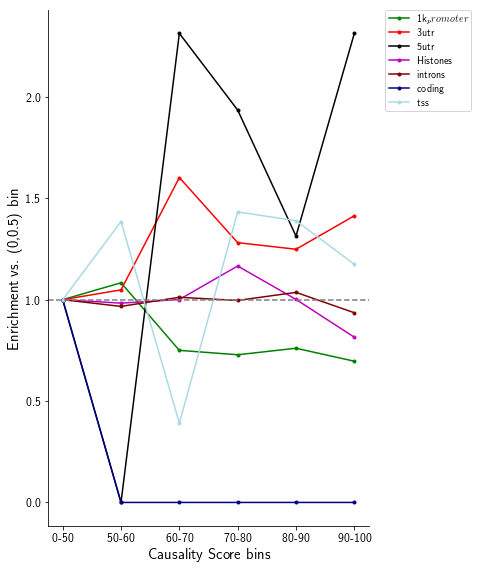

In [8]:
# Plot TSS/TES/UTR
bins = np.percentile(data[data["best.q"]<=MINQ]["best.score"], q = percentiles)
data1 = data1[data1["best.score"] >= 0]
data = data1 # TODO remove?
#EE =GG.loc[GG['E.tissues']>=1] # Restricts to eSTRs?
#data = data1.loc[data1['gene'].isin(list(EE['gene']))]

keys = list(FEATURES.keys()) + ["tss"]
binlabels = []
scores = {}
bases = {}
for key in keys: scores[key] = []

for i in range(len(bins)-1):
    lb = bins[i]
    ub = bins[i+1] 
    x = data[(data["best.score"]>lb) & (data["best.score"]<= ub) & (data["best.q"]<=MINQ)]
    for key in keys:
        feature_counts = x[key].apply(lambda x: abs(x)>0)  
        feature_perc = np.mean(feature_counts)
        if i == 0:
            print("%s,%s"%(key, sum(feature_counts)))
            bases[key] = feature_perc
        scores[key].append(feature_perc*1.0/bases[key])
    binlabels.append("%s-%s"%(percentiles[i], percentiles[i+1]))

fig = plt.figure()
fig.set_size_inches((10, 8))
COL = ["green","red","black",'m','maroon', 'navy','lightblue', 'pink', 'mediumpurple', 'orange','yellow',"blue","gray"]
ax = fig.add_subplot(121)
i = 0
for key in keys:
    ax.plot(range(len(binlabels)), scores[key], marker=".", color=COL[i], label=key)
    i += 1
ax.set_xlabel("Causality Score bins", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()